# Notebook for detecting multi-resolution clonal structures

This notebook reproduces the plots found in the accompanying paper, and loads parameters from a cached output file. Experiments can be re-produced using the scripts found in the above directory. This will also generate additional run-time plots using WandB logging callbacks.

In [131]:
import numpy as np
import pickle as pkl
import torch
import pandas as pd
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
import palettable
from palettable.colorbrewer.qualitative import Set1_6 as pallette

import TCGA
from WaveletVAE.src.WaveLSTM.models.base import WaveletBase

sns.set()
sns.set_palette(pallette.mpl_colors)

# Get data

In [53]:
dm = TCGA.data_modules.CHISEL_S0E.loaders.DataModule(batch_size=32, sampler=False, chr_length=256)

data = []
for loader in [dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()]:
    features, labels = [], []
    for batch in iter(loader):
        features.append(batch["feature"])
        labels.append(batch["label"])
    data.append({"feature": torch.concat(features, 0).numpy().reshape((-1, 2, 22, 256)),
                 "label": torch.concat(labels, 0).numpy()}
               )

In [54]:
# Report counts and order labels
label_order = []
for data_set, data_split in zip(["Training set", "Validation set", "Test set"], data):
    print(f"\n{data_set}\n==================")
    print(f"{data_split['feature'].shape[0]} samples composed of")
    
    for lbl, cnt in zip(*np.unique(data_split['label'], return_counts=True)):
        print(f"label {lbl} with count {cnt}")

    label_order.append(np.argsort(data_split["label"])
)


Training set
1158 samples composed of
label 0 with count 324
label 1 with count 127
label 2 with count 45
label 3 with count 14
label 4 with count 624
label 5 with count 24

Validation set
145 samples composed of
label 0 with count 34
label 1 with count 24
label 2 with count 6
label 3 with count 4
label 4 with count 74
label 5 with count 3

Test set
145 samples composed of
label 0 with count 32
label 1 with count 17
label 2 with count 7
label 3 with count 2
label 4 with count 84
label 5 with count 3


## Visualise each set's channel's and strands

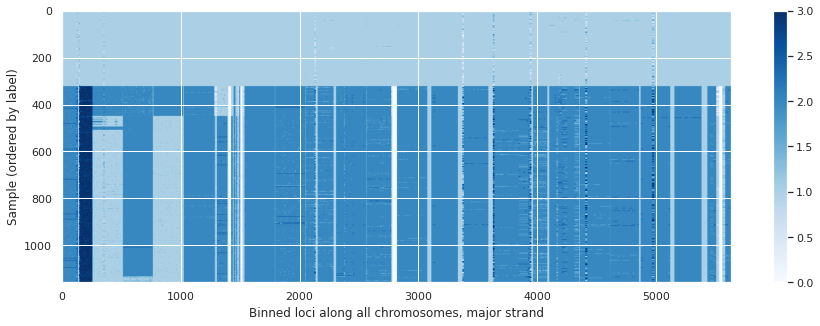

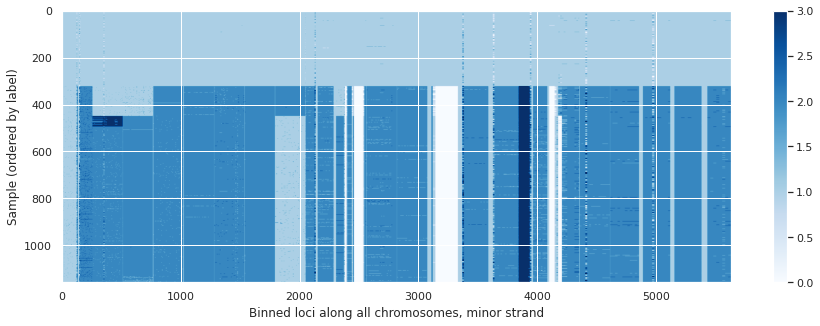

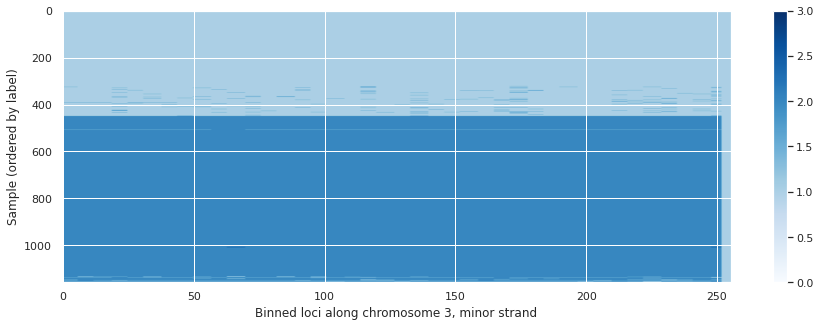

In [114]:
subset = 0           # Training set = 0, Validation set = 1, Test set = 2

# Stacked channels
for strand in range(1,3):
    plt.figure(figsize=(15, 5))
    tmp = data[subset]["feature"][label_order[subset], strand-1, :, :].reshape((-1, 22*256))
    plt.imshow(tmp, aspect='auto', cmap="Blues", vmin=0, vmax=3)
    plt.ylabel("Sample (ordered by label)")
    plt.xlabel(f"Binned loci along all chromosomes, {'major' if strand == 1 else 'minor'} strand")
    plt.colorbar()
    plt.show()

 
# Individual channel and strand
chromosome = 3          # 1,...,22
strand = 2           # 1 or 2

plt.figure(figsize=(15, 5))
plt.imshow(data[subset]["feature"][label_order[subset], strand-1, chromosome-1, :], aspect='auto', cmap="Blues", vmin=0, vmax=3)
plt.ylabel("Sample (ordered by label)")
plt.xlabel(f"Binned loci along chromosome {chromosome}, {'major' if strand == 1 else 'minor'} strand")
plt.colorbar()
plt.show()

## Due to class imbalance, plot the first 10 of each clone to see more clearly

There are still variations within each clone

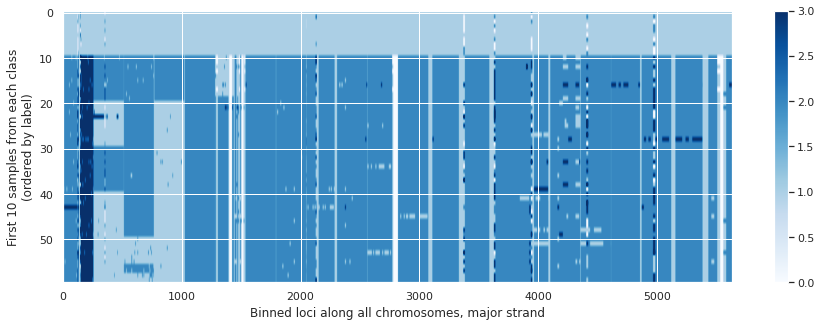

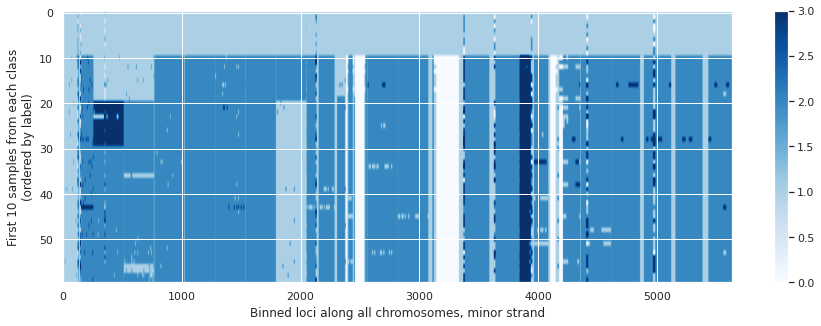

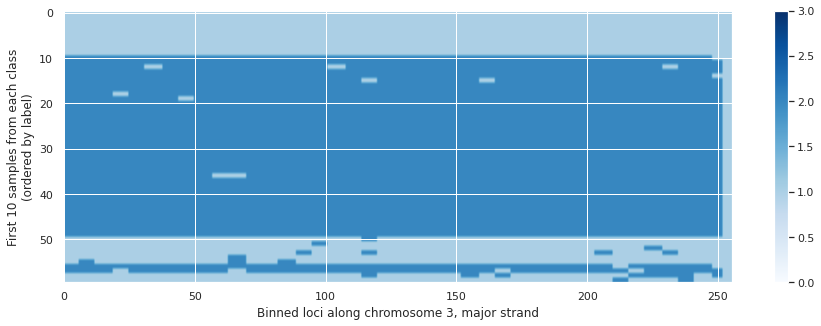

In [117]:
top_k = [np.where(data[subset]["label"] == l)[0][:10] for l in range(6)]
top_6k = np.concatenate(top_k, 0)

for strand in range(1,3):
    # Stacked channels
    plt.figure(figsize=(15, 5))
    tmp = data[subset]["feature"][top_6k, strand-1, :, :].reshape((-1, 22*256))
    plt.imshow(tmp, aspect='auto', cmap="Blues", vmin=0, vmax=3)
    plt.ylabel("First 10 samples from each class\n(ordered by label)")
    plt.xlabel(f"Binned loci along all chromosomes, {'major' if strand == 1 else 'minor'} strand")
    plt.colorbar()
    plt.show()

# Individual channel and strand
chromosome = 3          # 1,...,22
strand = 1           # 1 or 2

plt.figure(figsize=(15, 5))
plt.imshow(data[subset]["feature"][top_6k, strand-1, chromosome-1, :], aspect='auto', cmap="Blues", vmin=0, vmax=3)
plt.ylabel("First 10 samples from each class\n(ordered by label)")
plt.xlabel(f"Binned loci along chromosome {chromosome}, {'major' if strand == 1 else 'minor'} strand")
plt.colorbar()
plt.show()

From top to bottom. 

* Clone I, a diploid clone comprised of mostly normal cells, is clearly distinguishable.
* Clone II
* Clone III
* Clone IV
* Clone V
* Clone VI most notably has a deletion on chromosome 3 of the major strand, or an insertion on chromosome 3 of the minor strand. Particularly on the minor strand, this characteristic is shared with other clones.

# Model visualisations

Additional visualisation are provided at run-time with WandB logging callbacks.

Replace log file to view the same plots for other model types

    Attentive autoencoder:
         "../logs/a-ae-output.pkl"


In [118]:
with open("../logs/a-ae-output.pkl", 'rb') as file:
    meta_results = pkl.load(file)

# wave-LSTM outputs    
J = len(meta_results["resolution_embeddings"])
lbls = meta_results["labels"].cpu().numpy()
Mbar = torch.mean(meta_results["M"], axis=1).cpu().numpy()
Mflat = torch.flatten(meta_results["M"], start_dim=1).cpu().numpy()
A = meta_results["attention"]
print(f"Available outputs: {[i for i in meta_results.keys()]}")

Available outputs: ['masked_inputs', 'masked_targets', 'resolution_embeddings', 'attention', 'M', 'masked_predictions', 'labels']


# Source-separation module

Visualise the source-separated inputs.

Any discrete wavelet can be used. We used the Haar wavelet throughout for simplicity, but different wavelets may suit different tasks.

In [119]:
# channel = 1                  # 1 or 2
# cls = 6                      # 1,2,...,6
# discrete_wavelet = "haar"    # supported discrete examples: "haar", "dbN", "symN", "biorN", "rbioN","dmey"
#                              # We use a PyTorch extension of the pywt package which should support discrete wavelets found here:
#                              #       https://pywavelets.readthedocs.io/en/latest/regression/wavelet.html
# paper = False                # paper-ready plots

# X = dm.signals_no_noise[lbl_idx, :]
# loci = X.shape[-1]

# print("Original (noise-free) input signal")
# plt.figure(figsize=(5,3))
# plt.plot(np.linspace(0, loci, loci), X[cls-1, channel-1, :], lw=3)
# if paper:
#     plt.xticks([]); plt.yticks([])
#     plt.savefig(f"input_c{channel}.png", dpi=500, format='png', transparent=True); 
# else:
#     plt.ylim((-1.2,1.2))
# plt.show()

# print("Source-separated input signals")
# wavelet_reducer = WaveletBase(X.shape[-1], wavelet=discrete_wavelet)
# masked_inputs, _ = wavelet_reducer.sequence_mask(torch.from_numpy(X))
# loci = masked_inputs[0].shape[-1]
# for j in range(len(masked_inputs)):
#     plt.figure(figsize=(5,3))
#     plt.plot(np.linspace(0, loci, loci), masked_inputs[j].cpu().numpy()[cls-1, channel-1, :], lw=3)
#     if paper:
#         plt.xticks([]); plt.yticks([])
#         plt.savefig(f"source_sep_input_c{channel}j{j+1}.png", dpi=500, format='png', transparent=True)
#     else:
#         plt.ylim((-1.2,1.2))


AttributeError: 'DataModule' object has no attribute 'signals_no_noise'

# Visualise Wave-LSTM encoder output

In [129]:
reduce_method = "tSNE"         # tSNE or umap

if reduce_method.lower() == "umap":
    reducer = umap.UMAP()
elif reduce_method.lower() == "tsne":
    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)
else:
    raise NotImplementedError

# axis labels
latent1 = f"{reduce_method}-1"
latent2 = f"{reduce_method}-2"

## Resolution-embeddings (vs. source-separated inputs)

We visualise the learnt $h_j$, and compare how this differs from source-separated input $X_j$. 

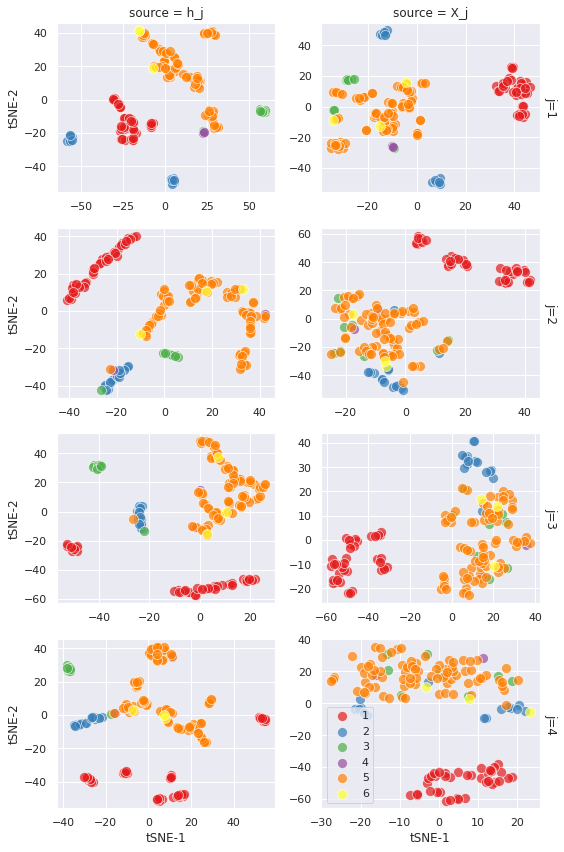

In [132]:
data = []
for j_res, j_name in zip([i for i in range(J)], [f"{j+1}" for j in range(J)]): 

    h_j = meta_results["resolution_embeddings"][j_res].cpu().numpy()
    x_j = meta_results["masked_inputs"][j_res].cpu().numpy()

    # Projection of scale embeddings, and source separated input
    for val, val_name in zip([h_j, x_j], ["h_j", "X_j"]):

        val = val.reshape((val.shape[0], -1))           # Reshape x_j to flatten channels
        val = StandardScaler().fit_transform(val)       # Scale before any transform
        
        embedding = reducer.fit_transform(val)
        for i in range(embedding.shape[0]):
            data.append([embedding[i, 0], embedding[i, 1], 
                         val_name,
                         j_name, lbls[i] + 1])  

df_emb = pd.DataFrame(data, columns=[latent1, latent2, "source", "resolution", "class"])
df_emb.head()

# Plot
g = sns.FacetGrid(df_emb, row="resolution", col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")
plt.legend()

We find that $h_j$ benefits from the information flow through the LSTM model. Embeddings are improved by

* the additional label/task information, leading to adaptive filtering.
* the ability of the LSTM model to pass information through the recurrent cell states. E.g. Whilst the orange class was separable at $X_{j=4}$, and subsequently not - within the resolution embeddings that information has been retained for $h_{j\geq4}$. Note, this behaviour can be controlled through reducing and increasing the capacity of the hidden states.


## Plot selective resolution embeddings (paper plot)

This is the paper plot version of the above section

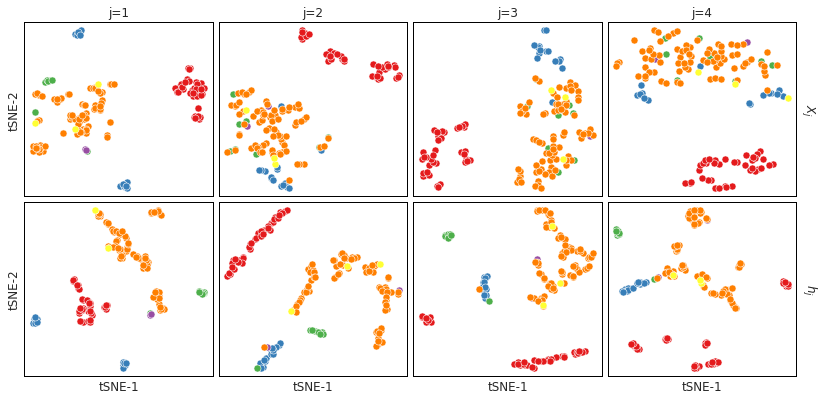

In [139]:
resolutions = [1,2,3,4]         # 1,2,3,...,J=4
sources = ["X_j", "h_j"]

df_fig2 = df_emb[df_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig2 = df_fig2[df_fig2["source"].isin(sources)]
# df_fig2 = df_fig2[df_fig2["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.FacetGrid(df_fig2, col="resolution", row="source", hue="class", 
                  row_order=sources,
                  margin_titles=True, despine=False, height=3, aspect=1, sharex=False, sharey=False)
g.map(sns.scatterplot, f"{reduce_method}-1", f"{reduce_method}-2", alpha=1, s=50)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="j={col_name}", row_template="${row_name}$")    # {row_name}
    

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=f"{reduce_method}-1", clear_inner=True, )
g.set_ylabels(label=f"{reduce_method}-2", clear_inner=True, )

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
# plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.gcf().set_size_inches(8, 3.5)
        
plt.savefig("resolution_embeddings.png", dpi=500, format='png', transparent=True)

## Visualisation of self-attention

We can also visualise the learnt self-attention, allowing us to see which resolutions the model thought were predictive.

(145, 4)


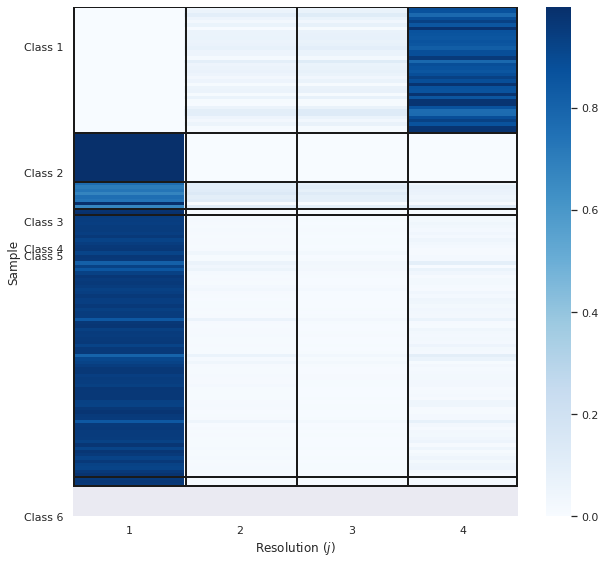

In [149]:
# Order samples by label
permute_idx = np.argsort(lbls)
ord_lbls = lbls[permute_idx]
ord_attention = A[permute_idx, :, :]

# average over attention hops:   [batch_size, num_multiscales]
ord_attention = torch.mean(ord_attention, dim=1).cpu().numpy()  
print(ord_attention.shape)

# Nested ordering (by biclustering attention)
attention_new = np.zeros_like(ord_attention)
for _lbl in np.unique(ord_lbls):
    lbl_idx = np.where(ord_lbls == _lbl)[0]
    atn_cls = ord_attention[lbl_idx, :]
    biclustering = SpectralBiclustering(n_clusters=(1, 1), method="log", random_state=0)
    biclustering.fit(atn_cls)
    atn_cls = atn_cls[np.argsort(biclustering.row_labels_)]
    attention_new[lbl_idx, :]  = atn_cls#[:, np.argsort(biclustering.column_labels_)]
attention = attention_new


# Plot
fig, ax = plt.subplots(1, 1, figsize=(9,8))
sns.heatmap(attention, ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1

# Add horizontal lines
y_tick_locations = [np.where(ord_lbls == _lbl)[0][0] for _lbl in np.unique(ord_lbls)]
for y_tick in y_tick_locations:
    ax.hlines(y=y_tick+0.1, xmin=0, xmax=20, linewidth=2, color='k')
ax.hlines(y=attention.shape[0]-0.1, xmin=0, xmax=20, linewidth=2, color='k')

# Add vertical lines
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick+0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')
ax.vlines(x=attention.shape[1]-0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')

    
ax.set_yticks([yi+attention.shape[0]/12 for yi in y_tick_locations])
# ax.set_yticks([], minor=True)
# ax.yaxis.grid(True, which='major', lw=1, ls='-', color='k')
ax.set_yticklabels([f"Class {i+1}" for i in np.unique(ord_lbls)])
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)

ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Sample")    # permuted

plt.tight_layout()
plt.savefig("attention.png", dpi=500, format='png', transparent=True)

## Visualisation of the multi-resolution embedding

We can visualise the embedding tensor $M$ by either flattening, or taking the average across hops. For this example $r_{\text{hops}}=1$, and so they are equivalent.

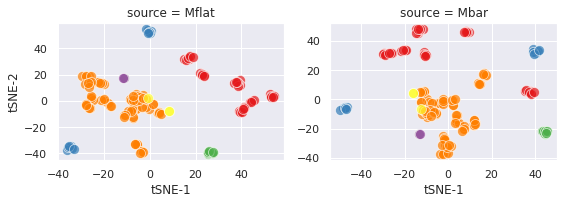

In [150]:
data = []

for Mvar, Mname in zip([Mflat, Mbar], ["Mflat", "Mbar"]):

    embedding = reducer.fit_transform(Mvar.reshape((Mvar.shape[0], -1)))

    for i in range(embedding.shape[0]):
        data.append([embedding[i, 0], embedding[i, 1], 
                     Mname,
                     lbls[i] + 1])  

df_mres_emb = pd.DataFrame(data, columns=[latent1, latent2, "source", "class"])

# Plot
g = sns.FacetGrid(df_mres_emb, col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)


## Plot flattened multi-resolution embeddings (in paper)

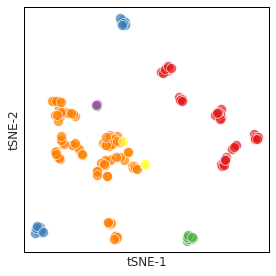

In [151]:
sources = ["Mflat"]

df_mres_emb = df_mres_emb[df_mres_emb["source"].isin(sources)]
# df_mres_emb = df_mres_emb[df_mres_emb["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.FacetGrid(df_mres_emb,  col="source", hue="class", margin_titles=True, despine=False, height=4, aspect=1, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=latent1, clear_inner=True, )
g.set_ylabels(label=latent2, clear_inner=True, )

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
plt.tight_layout()
        
plt.savefig("multires_emb_flat.png", dpi=500, format='png', transparent=True)